# Comparaison de la similarité des mots 'learning, 'memory', 'association', 'language' et 'knowledge' à travers le temps depuis 1800 à 1990

## Utilisation de l'outil HistWords (https://nlp.stanford.edu/projects/histwords/)

In [2]:
from representations.embedding import Embedding, SVDEmbedding
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import  pickle

import heapq

import numpy as np
from sklearn import preprocessing

def load_pickle(filename):
    fp = open(filename, "rb")
    return pickle.load(fp)
#, lines

class Embedding:
    """
    Base class for all embeddings. SGNS can be directly instantiated with it.
    """

    def __init__(self, vecs, vocab, normalize=True, **kwargs):
        self.m = vecs
        self.dim = self.m.shape[1]
        self.iw = vocab
        self.wi = {w:i for i,w in enumerate(self.iw)}
        if normalize:
            self.normalize()

    def __getitem__(self, key):
        if self.oov(key):
            raise KeyError
        else:
            return self.represent(key)

    def __iter__(self):
        return self.iw.__iter__()

    def __contains__(self, key):
        return not self.oov(key)

    @classmethod
    def load(cls, path, normalize=True, add_context=False, **kwargs):
        mat = np.load(path + "-w.npy", mmap_mode="c")
        if add_context:
            mat += np.load(path + "-c.npy", mmap_mode="c")
        iw = load_pickle(path + "-vocab.pkl")
        return cls(mat, iw, normalize)

    def get_subembed(self, word_list, **kwargs):
        word_list = [word for word in word_list if not self.oov(word)]
        keep_indices = [self.wi[word] for word in word_list]
        return Embedding(self.m[keep_indices, :], word_list, normalize=False)

    def reindex(self, word_list, **kwargs):
        new_mat = np.empty((len(word_list), self.m.shape[1]))
        valid_words = set(self.iw)
        for i, word in enumerate(word_list):
            if word in valid_words:
                new_mat[i, :] = self.represent(word)
            else:
                new_mat[i, :] = 0
        return Embedding(new_mat, word_list, normalize=False)

    def get_neighbourhood_embed(self, w, n=1000):
        neighbours = self.closest(w, n=n)
        keep_indices = [self.wi[neighbour] for _, neighbour in neighbours]
        new_mat = self.m[keep_indices, :]
        return Embedding(new_mat, [neighbour for _, neighbour in neighbours])

    def normalize(self):
        preprocessing.normalize(self.m, copy=False)

    def oov(self, w):
        return not (w in self.wi)

    def represent(self, w):
        if w in self.wi:
            return self.m[self.wi[w], :]
        else:
            print("OOV: ", w)
            return np.zeros(self.dim)

    def similarity(self, w1, w2):
        """
        Assumes the vectors have been normalized.
        """
        sim = self.represent(w1).dot(self.represent(w2))
        return sim

    def closest(self, w, n=10):
        """
        Assumes the vectors have been normalized.
        """
        scores = self.m.dot(self.represent(w))
        return heapq.nlargest(n, list(zip(scores, self.iw)))


class SVDEmbedding(Embedding):
    """
    SVD embeddings.
    Enables controlling the weighted exponent of the eigenvalue matrix (eig).
    Context embeddings can be created with "transpose".
    """

    def __init__(self, path, normalize=True, eig=0.0, **kwargs):
        ut = np.load(path + '-u.npy', mmap_mode="c")
        s = np.load(path + '-s.npy', mmap_mode="c")
        vocabfile = path + '-vocab.pkl'
        self.iw = load_pickle(vocabfile)
        self.wi = {w:i for i, w in enumerate(self.iw)}

        if eig == 0.0:
            self.m = ut
        elif eig == 1.0:
            self.m = s * ut
        else:
            self.m = np.power(s, eig) * ut

        self.dim = self.m.shape[1]

        if normalize:
            self.normalize()

class GigaEmbedding(Embedding):
    def __init__(self, path, words=[], dim=300, normalize=True, **kwargs):
        seen = []
        vs = {}
        for line in open(path):
            split = line.split()
            w = split[0]
            if words == [] or w in words:
                if len(split) != dim+1:
                    continue
                seen.append(w)
                vs[w] = np.array(list(map(float, split[1:])), dtype='float32')
        self.iw = seen
        self.wi = {w:i for i,w in enumerate(self.iw)}
        self.m = np.vstack(vs[w] for w in self.iw)
        if normalize:
            self.normalize()

In [4]:
class SequentialEmbedding:
    def __init__(self, year_embeds, **kwargs):
        self.embeds = year_embeds
 
    @classmethod
    def load(cls, path, years, **kwargs):
        embeds = collections.OrderedDict()
        for year in years:
            embeds[year] = Embedding.load(path + "/" + str(year), **kwargs)
        return SequentialEmbedding(embeds)

    def get_embed(self, year):
        return self.embeds[year]

    def get_subembeds(self, words, normalize=True):
        embeds = collections.OrderedDict()
        for year, embed in self.embeds.items():
            embeds[year] = embed.get_subembed(words, normalize=normalize)
        return SequentialEmbedding(embeds)

    def get_time_sims(self, word1, word3):
       time_sims = collections.OrderedDict()
       for year, embed in self.embeds.items():
           time_sims[year] = embed.similarity(word1, word3)
       return time_sims

    def get_seq_neighbour_set(self, word, n=3):
        neighbour_set = set([])
        for embed in self.embeds.itervalues():
            closest = embed.closest(word, n=n)
            for _, neighbour in closest:
                neighbour_set.add(neighbour)
        return neighbour_set

    def get_seq_closest(self, word, start_year, num_years=10, n=10):
        closest = collections.defaultdict(float)
        for year in range(start_year, start_year + num_years):
            embed = self.embeds[year]
            year_closest = embed.closest(word, n=n*10)
            for score, neigh in year_closest.items():
                closest[neigh] += score
        return sorted(closest, key = lambda word : closest[word], reverse=True)[0:n]

    def get_word_subembeds(self, word, n=3, num_rand=None, word_list=None):
        if word_list == None:
            word_set = self.get_seq_neighbour_set(word, n=n)
            if num_rand != None:
                word_set = word_set.union(set(random.sample(self.embeds.values()[-1].iw, num_rand)))
            word_list = list(word_set)
        year_subembeds = collections.OrderedDict()
        for year,embed in self.embeds.items():
            year_subembeds[year] = embed.get_subembed(word_list)
        return SequentialEmbedding.from_ordered_dict(year_subembeds)


class SequentialSVDEmbedding(SequentialEmbedding):

    def __init__(self, path, years, **kwargs):
        self.embeds = collections.OrderedDict()
        for year in years:
            self.embeds[year] = SVDEmbedding(path + "/" + str(year), **kwargs)

In [5]:
def similarity_time(w1,w2, showDataframe = True) :
    fiction_embeddings = SequentialEmbedding.load("sgns", range(1800, 2000, 10))
    time_sims = fiction_embeddings.get_time_sims(w1, w2) 
    if showDataframe :
        df = pd.DataFrame(time_sims, columns=time_sims.keys(), index=["similarité"])
        print(df)
    else :
        return time_sims
        

## Test sur un exemple connu : le mot "gay"

Avant de tester notre fonction similarity_time sur nos mots cibles testons d'abord sur des mots sur lesquels nous savons que le passage du temps à eu un effet. Effectivement nous savons que le mot gay était avant plus associé à des choses joyeuses, douces alors que maintenant ce mot sert maintenant presque exclusivement à définir une orientation sexuel. Nous allons donc tester notre similarity_time sur les mots "gay" et "sweet" ainsi que sur les mots "gay" et "lesbian"

In [59]:
similarity_time("gay","sweet")

                1800      1810      1820      1830      1840      1850  \
similarité  0.327138  0.248716  0.202675  0.306266  0.229045  0.264577   

                1860      1870      1880      1890      1900      1910  \
similarité  0.252583  0.189632  0.262368  0.223221  0.267444  0.277085   

                1920      1930      1940      1950      1960      1970  \
similarité  0.254173  0.295886  0.289731  0.427396  0.373789  0.254806   

                1980      1990  
similarité  0.204326  0.044531  


In [32]:
similarity_time("gay","lesbian")

            1800  1810  1820  1830  1840  1850  1860  1870  1880  1890  1900  \
similarité   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

            1910  1920  1930  1940  1950  1960      1970     1980      1990  
similarité   0.0   0.0   0.0   0.0   0.0   0.0  0.322096  0.46853  0.703259  


Effectivement on observe bien que plus les décennies ont passé plus la similarité entre "gay" et "sweet" à diminué alors que celle entre "gay" et "lesbian" à énormément augmenté.

# Test sur nos mots cibles

In [19]:
similarity_time("memory","association")

                1800     1810      1820      1830      1840      1850  \
similarité  0.034647  0.12422  0.080095  0.096103  0.109388  0.049883   

                1860      1870      1880      1890      1900      1910  \
similarité  0.001508  0.059033  0.054754  0.084792  0.013121  0.110168   

                1920      1930      1940      1950      1960      1970  \
similarité  0.038896  0.007395 -0.018515 -0.028191 -0.033366 -0.127776   

                1980      1990  
similarité -0.125503 -0.080579  


In [ ]:
similarity_time("memory","learning")

                1800      1810      1820      1830      1840     1850  \
similarité  0.072642  0.045824  0.094691  0.141627  0.088779  0.14677   

                1860      1870      1880      1890      1900      1910  \
similarité  0.131067  0.103492  0.097442  0.079914  0.139472  0.206035   

                1920      1930     1940      1950      1960      1970  \
similarité  0.123329  0.125343  0.18225  0.174689  0.226547  0.254108   

                1980      1990  
similarité  0.295798  0.312156  


In [25]:
similarity_time("association","learning")

                1800      1810      1820      1830      1840      1850  \
similarité -0.104168 -0.075727 -0.011688  0.017197  0.041401  0.050149   

                1860      1870      1880      1890      1900      1910  \
similarité  0.065278  0.069797 -0.007901  0.106857  0.001766  0.082898   

                1920      1930      1940      1950      1960      1970  \
similarité  0.055245  0.038563  0.031634  0.063922  0.089339  0.037373   

                1980      1990  
similarité  0.093382  0.061193  


In [26]:
similarity_time("knowledge","memory")

                1800      1810      1820      1830      1840      1850  \
similarité  0.038386  0.098665  0.123807  0.120079  0.054567  0.093735   

                1860     1870      1880      1890      1900      1910  \
similarité  0.072891  0.07237  0.031768  0.116036  0.063744  0.103811   

                1920      1930      1940      1950      1960      1970  \
similarité  0.062713  0.069215  0.076458  0.123774  0.168486  0.164486   

                1980      1990  
similarité  0.148976  0.139785  


In [27]:
similarity_time("knowledge","learning")

                1800      1810      1820      1830      1840      1850  \
similarité  0.412475  0.449307  0.477414  0.408189  0.425047  0.372967   

                1860      1870      1880      1890      1900      1910  \
similarité  0.411801  0.413507  0.397707  0.415102  0.440167  0.342561   

                1920      1930      1940      1950      1960      1970  \
similarité  0.331258  0.359968  0.336628  0.326367  0.344778  0.328362   

                1980      1990  
similarité  0.308056  0.273009  


In [28]:
similarity_time("knowledge","association")

                1800      1810      1820     1830      1840      1850  \
similarité  0.097695  0.034857  0.049427  0.10645  0.034639  0.163573   

                1860      1870      1880      1890      1900      1910  \
similarité  0.083412  0.060511  0.105391  0.112208  0.081057  0.034291   

                1920      1930      1940      1950      1960      1970  \
similarité  0.062461  0.002364 -0.013622 -0.007499  0.017433 -0.055876   

                1980      1990  
similarité -0.050556 -0.084179  


In [7]:
similarity_time("language","memory")

                1800      1810      1820      1830      1840      1850  \
similarité  0.055613  0.020142  0.036123  0.116712  0.003492  0.040029   

                1860      1870      1880      1890      1900      1910  \
similarité  0.067134  0.061076  0.099422  0.077482  0.107106  0.082781   

                1920      1930      1940      1950     1960      1970  \
similarité  0.073574  0.078469  0.087316  0.096187  0.08987  0.138763   

               1980      1990  
similarité  0.18329  0.223537  


In [8]:
similarity_time("language","learning")

                1800      1810      1820      1830      1840     1850  \
similarité  0.256375  0.231532  0.144075  0.228883  0.192575  0.24627   

                1860      1870      1880     1890     1900      1910  \
similarité  0.237298  0.271616  0.264531  0.26698  0.29121  0.269769   

                1920      1930      1940      1950      1960      1970  \
similarité  0.327581  0.267911  0.252443  0.320034  0.311199  0.394649   

                1980      1990  
similarité  0.374217  0.392985  


In [13]:
similarity_time("language","knowledge")

                1800      1810      1820      1830      1840      1850  \
similarité  0.341053  0.272334  0.223711  0.290829  0.263639  0.275903   

                1860      1870      1880      1890      1900      1910  \
similarité  0.271624  0.279748  0.302023  0.306734  0.257569  0.261709   

                1920      1930      1940     1950      1960      1970  \
similarité  0.287734  0.254219  0.345429  0.29501  0.339814  0.287143   

                1980      1990  
similarité  0.307467  0.345312  


In [10]:
similarity_time("language","association")

                1800     1810      1820      1830      1840      1850  \
similarité  0.031691  0.06346  0.101977  0.082019  0.075095  0.048736   

                1860      1870      1880      1890      1900      1910  \
similarité  0.022602  0.029565  0.001306  0.030741  0.086947 -0.011711   

                1920      1930      1940     1950      1960      1970  \
similarité  0.097593  0.094405  0.107422  0.09178  0.148757  0.089538   

                1980     1990  
similarité  0.124682  0.11123  


Difficile d'avoir une conclusion précise, il semble avoir de petites différences pour la similarité de chaque duo de mots mais sont-elles vraiment significative ?

La plus grande diférence semble être entre "memory" et "learning" qui ont une similarité de 0.07 en 1800 et de 0.31 en 1990. Ces deux termes semble donc s'être rapprochés au fur et à mesure du temps.

Pour avoir une lisibilité plus facile regardons ces résultats à l'aide de graphiques

# Résultat sous forme de graphiques :

In [14]:

def similarity_time_graph(focusWord, listOfWords):
    
    print("comparaison des mots cibles avec le mot '" + focusWord + "' entre 1800 et 1990")
    
    for word in listOfWords :
        sim = similarity_time(focusWord,word, showDataframe = False)
        plt.plot(list(sim.keys()), list(sim.values()), label=word)
        
    plt.xlabel('Période')
    plt.ylabel('Similarité')
    plt.axis([1800, 2000, -0.2, 1])
    plt.legend()  
    plt.show()

comparaison des mots cibles avec le mot 'gay' entre 1800 et 1990


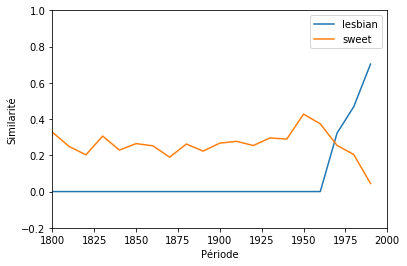

In [72]:
similarity_time_graph("gay", ["lesbian","sweet"])

comparaison des mots cibles avec le mot 'memory' entre 1800 et 1990


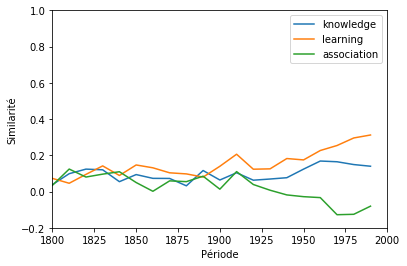

In [67]:
similarity_time_graph("memory", ["knowledge","learning","association","language"])

comparaison des mots cibles avec le mot 'learning' entre 1800 et 1990


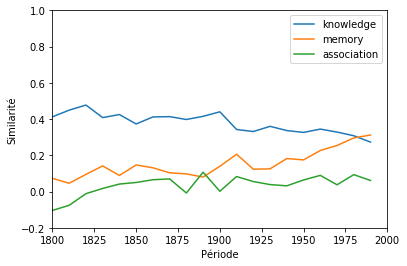

In [68]:
similarity_time_graph("learning", ["knowledge","memory","association","language"])

comparaison des mots cibles avec le mot 'association' entre 1800 et 1990


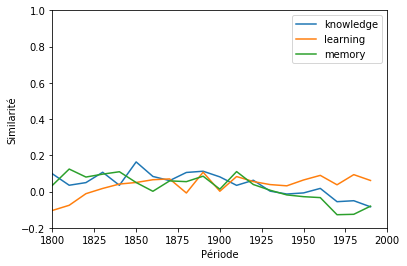

In [69]:
similarity_time_graph("association", ["knowledge","learning","memory","language"])

comparaison des mots cibles avec le mot 'knowledge' entre 1800 et 1990


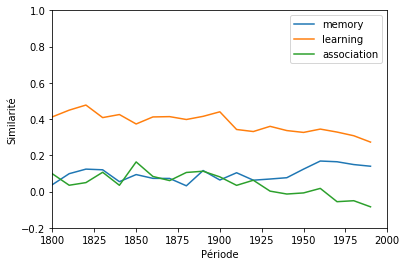

In [73]:
similarity_time_graph("knowledge", ["memory","learning","association","language"])

comparaison des mots cibles avec le mot 'language' entre 1800 et 1990


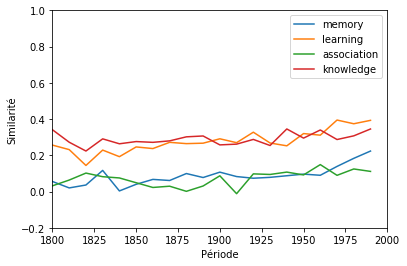

In [15]:
similarity_time_graph("language", ["memory","learning","association","knowledge"])